In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [348]:
# Import datasets
#mask = xr.open_dataset('/data/users/hgilmour/initial_tracks/tobac_initial_tracks/segmentation/regridded/regridded_segmentation_yearly_1998.nc')
mask = xr.open_dataset('/data/users/hgilmour/initial_tracks/tobac_initial_tracks/segmentation/segmentation_yearly_1998.nc')
mask = mask.segmentation_mask
mask #segmentation mask from tracking on Jan 2005 with [240, 200] and [1975, 10]

#precip = xr.open_dataset('/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_1998.nc')
precip = xr.open_dataset('/scratch/hgilmour/total_precip/yearly_files/total_precip_1998.nc')
precip = precip.unknown #precip dataset for Jan 2005 (NEED TO LATER CONVERT FROM KG M-2 S-1 TO MM/HR (X3600))

tracks = pd.read_hdf('/data/users/hgilmour/initial_tracks/tobac_initial_tracks/tracking/tracks_1998_01.h5', 'table')

#tb = xr.open_dataset('/data/users/hgilmour/tb/regridded/regridded_tb_1998.nc')
tb = xr.open_dataset('/data/users/hgilmour/tb/tb_1998.nc')
tb = tb.toa_outgoing_longwave_flux

#vert_vel = xr.open_dataset('/scratch/hgilmour/omega_new/regridded/regridded_omega_1998.nc')
vert_vel = xr.open_dataset('/scratch/hgilmour/omega_new/omega_1998.nc')
#vert_vel = vert_vel.dz_dt
vert_vel = vert_vel.upward_air_velocity
vert_vel = vert_vel[:,1:,:] # making sure there are 1360 latitudes rather than 1361


In [349]:
precip

<xarray.DataArray 'unknown' (time: 8760, latitude: 1360, longitude: 1360)>
[16202496000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01T00:30:00 ... 1998-12-31T23:30:00
  * longitude  (longitude) float32 275.0 275.0 275.0 275.1 ... 329.9 330.0 330.0
  * latitude   (latitude) float32 -40.04 -40.0 -39.96 ... 14.92 14.96 15.0
Attributes:
    units:         kg m-2 s-1
    grid_mapping:  latitude_longitude

In [350]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell
0,0,2,106.094677,542.929600,31239,240,1,1998-01-01 00:30:00,1998-01-01 00:30:00,-35.743217,296.948687,1,0 days 00:00:00
11,1,3,107.685873,552.813250,31490,240,12,1998-01-01 01:30:00,1998-01-01 01:30:00,-35.678772,297.348999,1,0 days 01:00:00
22,2,2,108.269844,561.840211,31852,240,23,1998-01-01 02:30:00,1998-01-01 02:30:00,-35.655121,297.714568,1,0 days 02:00:00
32,3,2,108.115039,575.691689,32671,240,33,1998-01-01 03:30:00,1998-01-01 03:30:00,-35.661391,298.275570,1,0 days 03:00:00
42,4,1,108.144396,590.299973,33018,240,43,1998-01-01 04:30:00,1998-01-01 04:30:00,-35.660202,298.867189,1,0 days 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,744,219,868.749690,542.063649,6256,240,8314,1998-02-01 00:30:00,1998-02-01 00:30:00,-4.855688,296.913619,1921,0 days 03:00:00
8325,745,192,862.976994,530.125648,4300,240,8326,1998-02-01 01:30:00,1998-02-01 01:30:00,-5.089482,296.430137,1921,0 days 04:00:00
8337,746,168,858.588397,531.833791,4954,240,8338,1998-02-01 02:30:00,1998-02-01 02:30:00,-5.267219,296.499312,1921,0 days 05:00:00
8345,747,161,858.465148,529.092454,4364,240,8346,1998-02-01 03:30:00,1998-02-01 03:30:00,-5.272211,296.388296,1921,0 days 06:00:00


In [351]:
mask.shape == precip.shape # checking whether the mask and precip files have the same shape
# next steps won't work if not


True

In [352]:
# Copy tracks dataset into new tracks_precip dataset to append precip data to
tracks = tracks.copy()

In [353]:
# Add columns to the tracks_precip dataframe ready to append data to later
tracks['total_precip'] = 0 #total precip from any precipitating pixel
tracks['rain_flag'] = 0 # total number of pixels that meet the 1mm/hr threshold
tracks['light_precip'] = 0 # total rain from all pixels where the rainfall threshold of 1 mm/hr is met
tracks['heavy_precip'] = 0 # total rain from all pixels where the heavy rainfall threshold of 10 mm/hr is met
tracks['extreme_precip'] = 0 # total rain from all pixels where the extreme rainfall threshold of 50 mm/hr is met
tracks['max_precip'] = 0 # maximum rainfall rate found over the masked area at that timstep
tracks['mean_precip_total'] = 0 # mean rainfall rate found over whole masked area (including non rainy pixels)

tracks['mean_precip'] = 0 # mean rainfall rate found over pixels that meet the precipitation threshold (> 1 mm/hr)


# Add cold core filter columns
tracks['tb_min'] = 0
tracks['tb_mean'] = 0
tracks['cold_core_flag'] = 0
tracks['tb_210'] = 0
tracks['tb_200'] = 0
tracks['tb_190'] = 0

# Add columns for vertical velocity (w)
tracks['w_max'] = float('NaN') # maximum vertical velocity
tracks['w_mean'] = float('NaN') # mean vertical velocity
tracks['w_mean_up'] = float('NaN') # mean vertical velocity of only positive values (i.e. upward motion)

# Add column for datetime
tracks['datetime'] = 0

# Add columns for latitude and longitude of variable maxima / minima
tracks['max_precip_lat'] = 0
tracks['max_precip_lon'] = 0
tracks['min_tb_lat'] = 0
tracks['min_tb_lon'] = 0
tracks['max_w_up_lat'] = 0
tracks['max_w_up_lon'] = 0
tracks['max_w_down_lat'] = 0
tracks['max_w_down_lon'] = 0


# # Add columns for colocated pixels of cold core <= 200K and precip > 1mm/hr
tracks['colocated_pixels'] = 0


In [354]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
0,0,2,106.094677,542.929600,31239,240,1,1998-01-01 00:30:00,1998-01-01 00:30:00,-35.743217,296.948687,1,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
11,1,3,107.685873,552.813250,31490,240,12,1998-01-01 01:30:00,1998-01-01 01:30:00,-35.678772,297.348999,1,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
22,2,2,108.269844,561.840211,31852,240,23,1998-01-01 02:30:00,1998-01-01 02:30:00,-35.655121,297.714568,1,0 days 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
32,3,2,108.115039,575.691689,32671,240,33,1998-01-01 03:30:00,1998-01-01 03:30:00,-35.661391,298.275570,1,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
42,4,1,108.144396,590.299973,33018,240,43,1998-01-01 04:30:00,1998-01-01 04:30:00,-35.660202,298.867189,1,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,744,219,868.749690,542.063649,6256,240,8314,1998-02-01 00:30:00,1998-02-01 00:30:00,-4.855688,296.913619,1921,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8325,745,192,862.976994,530.125648,4300,240,8326,1998-02-01 01:30:00,1998-02-01 01:30:00,-5.089482,296.430137,1921,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8337,746,168,858.588397,531.833791,4954,240,8338,1998-02-01 02:30:00,1998-02-01 02:30:00,-5.267219,296.499312,1921,0 days 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8345,747,161,858.465148,529.092454,4364,240,8346,1998-02-01 03:30:00,1998-02-01 03:30:00,-5.272211,296.388296,1921,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0


In [355]:
# remove cell values with -1 from tracks dataset
tracks = tracks[tracks.cell >= 0]
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
0,0,2,106.094677,542.929600,31239,240,1,1998-01-01 00:30:00,1998-01-01 00:30:00,-35.743217,296.948687,1,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
11,1,3,107.685873,552.813250,31490,240,12,1998-01-01 01:30:00,1998-01-01 01:30:00,-35.678772,297.348999,1,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
22,2,2,108.269844,561.840211,31852,240,23,1998-01-01 02:30:00,1998-01-01 02:30:00,-35.655121,297.714568,1,0 days 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
32,3,2,108.115039,575.691689,32671,240,33,1998-01-01 03:30:00,1998-01-01 03:30:00,-35.661391,298.275570,1,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
42,4,1,108.144396,590.299973,33018,240,43,1998-01-01 04:30:00,1998-01-01 04:30:00,-35.660202,298.867189,1,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,744,219,868.749690,542.063649,6256,240,8314,1998-02-01 00:30:00,1998-02-01 00:30:00,-4.855688,296.913619,1921,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8325,745,192,862.976994,530.125648,4300,240,8326,1998-02-01 01:30:00,1998-02-01 01:30:00,-5.089482,296.430137,1921,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8337,746,168,858.588397,531.833791,4954,240,8338,1998-02-01 02:30:00,1998-02-01 02:30:00,-5.267219,296.499312,1921,0 days 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8345,747,161,858.465148,529.092454,4364,240,8346,1998-02-01 03:30:00,1998-02-01 03:30:00,-5.272211,296.388296,1921,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0


In [356]:
tracks.rename(columns={'projection_x_coordinate': 'longitude', 'projection_y_coordinate': 'latitude'}, inplace=True)
tracks.longitude = tracks.longitude - 360

In [1]:
pd.set_option("display.max_columns", 50)


NameError: name 'pd' is not defined

In [358]:
tracks[tracks.cell == 35]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
133,15,189,996.084775,460.061626,2236,240,134,1998-01-01 15:30:00,1998-01-01 15:30:00,0.301384,-66.407447,35,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
144,16,268,995.522789,460.246742,3000,240,145,1998-01-01 16:30:00,1998-01-01 16:30:00,0.278623,-66.399950,35,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
158,17,315,992.480398,459.914108,3917,240,159,1998-01-01 17:30:00,1998-01-01 17:30:00,0.155405,-66.413421,35,0 days 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
172,18,326,989.035309,459.305533,5138,240,173,1998-01-01 18:30:00,1998-01-01 18:30:00,0.015880,-66.438066,35,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
187,19,316,983.960401,460.088418,6585,240,188,1998-01-01 19:30:00,1998-01-01 19:30:00,-0.189653,-66.406362,35,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
202,20,281,984.095425,457.113371,9622,240,203,1998-01-01 20:30:00,1998-01-01 20:30:00,-0.184185,-66.526842,35,0 days 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
221,21,246,978.668498,454.370483,10759,240,222,1998-01-01 21:30:00,1998-01-01 21:30:00,-0.403975,-66.637951,35,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0


In [359]:
cell_nos = tracks[tracks.latitude < -20]
cell_no = np.unique(cell_nos.cell.values[cell_nos.longitude < -50])

In [360]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [361]:
cell_no

array([   1,   48,   84,   87,  104,  157,  171,  180,  190,  205,  232,
        235,  287,  315,  334,  335,  369,  378,  510,  511,  562,  574,
        612,  613,  648,  651,  704,  705,  710,  750,  751,  752,  792,
        822,  851,  856,  900,  938,  974, 1034, 1085, 1173, 1314, 1344,
       1381, 1419, 1430, 1533, 1534, 1535, 1566, 1625, 1656, 1660, 1673,
       1724, 1727, 1749, 1777, 1785, 1840, 1888, 1899, 1902, 1903])

In [362]:
cells = np.unique(tracks.cell.values)
cells

array([   1,    8,    9,   22,   24,   26,   34,   35,   36,   38,   48,
         49,   55,   59,   61,   64,   66,   69,   79,   83,   84,   86,
         87,   96,  101,  104,  105,  112,  116,  117,  125,  130,  132,
        136,  137,  141,  145,  157,  165,  167,  170,  171,  173,  180,
        183,  189,  190,  199,  202,  205,  206,  211,  222,  224,  228,
        231,  232,  233,  235,  238,  239,  242,  271,  284,  287,  292,
        293,  300,  301,  305,  309,  313,  315,  318,  322,  326,  332,
        333,  334,  335,  338,  339,  340,  349,  358,  367,  369,  370,
        373,  378,  382,  391,  393,  396,  399,  400,  418,  427,  432,
        455,  463,  468,  471,  476,  490,  491,  497,  500,  501,  510,
        511,  524,  529,  531,  533,  540,  542,  543,  549,  553,  554,
        556,  562,  563,  569,  574,  578,  582,  585,  586,  591,  593,
        595,  603,  604,  612,  613,  615,  617,  618,  622,  627,  631,
        636,  644,  648,  651,  655,  660,  689,  7

In [363]:
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
    
    if mappable == tbs:
        label = 'Brightness temp (K)'
        ticks = range(180, 245, 10)

    elif mappable == precips:
        label = 'Precipitation (mm hr-1)'
        ticks = range(0, 140, 20)

    elif mappable == vel:
        label = 'Vertical velocity (m s-1)'
        ticks = range(-4, 4, 1)
        
    cax = divider.append_axes(loc, '5%', pad='3%', axes_class=mpl.pyplot.Axes)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label, ticks=ticks).set_label(label=label,size=15)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label, ticks=ticks)


In [364]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [365]:
import cartopy as crs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

Feature: 134
Frame: 15
Frame timestamp:  133   1998-01-01 15:30:00
Name: timestr, dtype: datetime64[ns]
Shape of seg: (1360, 1360)
rain features: 916
precip area: 198
Number of colocated pixels: 270
original frame timestamp:  133   1998-01-01 15:30:00
Name: timestr, dtype: datetime64[ns]
w frame number:  5
w frame timestamp:  <xarray.DataArray 'time' ()>
array('1998-01-01T15:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-01-01T15:00:00
Attributes:
    axis:           T
    standard_name:  time
    actual_range:   [245448. 254205.]
maximum w within mask: 6.5104193687438965
Skipping this frame and assinging NaN
Feature: 145
Frame: 16
Frame timestamp:  144   1998-01-01 16:30:00
Name: timestr, dtype: datetime64[ns]
Shape of seg: (1360, 1360)
rain features: 1034
precip area: 198
Number of colocated pixels: 362
Skipping this frame and assinging NaN
Feature: 159
Frame: 17
Frame timestamp:  158   1998-01-01 17:30:00
Name: timestr, dtype: datetime64[ns]


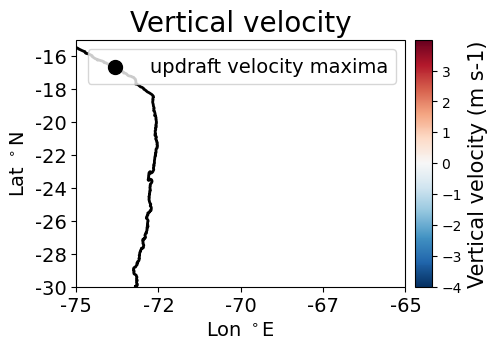

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

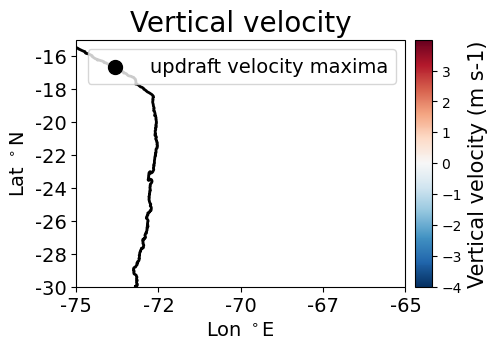

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

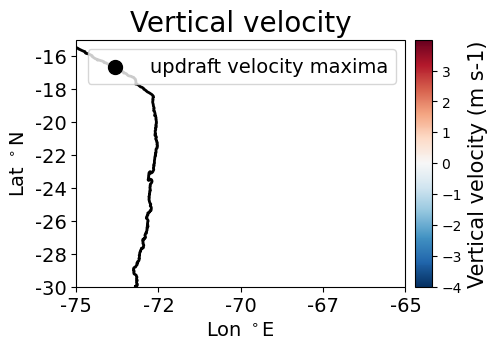

In [366]:
## TESTING LOOP FOR A SINGLE UNIQUE CELL (E.G. NUMBER 12) ##

## rainfall thresholds to use within filtering loop ##
precip_threshold = 1 #mm/hr
heavy_precip_threshold = 10 # mm/hr
extreme_precip_threshold = 50 # mm/hr (based on Marengo, J. A., Ambrizzi, T., Alves, L. M., Barreto, N. J., Simões Reboita, M., & Ramos, A. M. (2020). Changing trends in rainfall extremes in the metropolitan area of São Paulo: causes and impacts. Frontiers in Climate, 2, 3.)
precip_area = 198 # threshold for the minimum number of grid points that must be precipitating for a track to remain (and not be dropped from the tracks dataset)

cold_threshold = 210

## other parameters that need to be defined before loop ##
s = generate_binary_structure(2,2) # need this in loop later on
removed = 0 # need this for loop later on


cell = 35
subset = tracks[tracks.cell == cell]
precipitation_flag = 0
cold_core_flag = 0
rain_flag = 0
w_frame = 0 # assigning the frame number of the vertical velocity dataset to be 0 (i.e. vert_vel[w_frame,:,:,:] = vert_vel[0,:,:,:])

for feature in subset.feature.values: #find all the feature values for that unique cell / track (the feature value is a unique value for each feature in a frame /timestep)
    print("Feature:", feature)
    for frame in subset.frame[subset.feature == feature]: #find the frame / timestep that corresponds to the feature number
        print("Frame:", frame)
        print("Frame timestamp: ", str(subset['timestr'][subset.frame == frame]))

        subset['datetime'][(subset.frame == frame) & (subset.cell == cell)] = pd.to_datetime(subset['timestr'][subset.frame == frame]) # the time at the hourly frame

        if mask.shape == precip.shape:
        
            seg = mask[frame,:,:] #printing the segmentation mask which occurs in the same frame as the feature value
            #print(seg)
            prec = precip[frame,:,:] #printing the precip timesteps which occurs in the same frame as the feature value
            #print(prec)
            brightness_temp = tb[frame,:,:] # printing the tb timesteps which occurs in the same frame as the feature value
            brightness_temp = tb[frame,:,:] # printing the tb timesteps which occurs in the same frame as the feature value


            featureid = subset.feature[subset.frame == frame].values[0] #find the feature number at each timestep / frame of the cells lifetime (it changes over time and doesn't stay constant)
            #print('featureid: {}'.format(featureid)) #we now know all the feature numbers that belong to a single cell over its lifetime
            
            print("Shape of seg:", np.shape(seg))
            labels, num_labels = ndimage.label(seg, structure = generate_binary_structure(2,2)) #this line uses ndimage package for image processing. It generates arrays of numbers and decides what are joined together and what aren't.
            # In other words, it does image segmentation tasks, such as finding connected components and labeling objects in an image.
            # (i.e. it generates the locations of all contiguous fields of the segmentation mask that belong to a specific cell at a specific timestep and gives it a label. The number of labels is also recorded (the number of segmented areas in the timestep))

            if featureid not in seg: #check that the feature id number at each timestep is within the segmentation mask, if not, it is ignored and we continue
                continue
            else:

                label = np.unique(labels[seg == featureid])[0] #put a label where the labels match for both the feature id and the segmentation mask
                seg_mask = seg.where(labels == label)

                #create coordinates from mask
                seg_mask.coords['mask'] = (('latitude', 'longitude'), seg_mask.data)

                #apply mask to precip dataset
                precip_values = prec.where(seg_mask.coords['mask'].values > 0) # creating a new dataset called 'precip_values' with only the precip values where the seg_mask pixel is labelled as greater than 0 (i.e. the MCS region)
                #print('precip values: {}'.format(precip_values)
                array = precip_values.values.flatten() * 3600 # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                values = array[~np.isnan(array)] #removes NaNs from the precip array for further calculations
                #print(values)

                total_precip = np.nansum(values[values > 0]) #working out the total precip associated with the mask. First, values of 0 are removed to only consider precipitating pixels. Then np.nansum is used to compute the sum of all precipitating values within the mask.
                #print('total precip: {}'.format(total_precip))
                subset['total_precip'][(subset.feature == featureid) & (subset.frame == frame)  & (subset.cell == cell)] = total_precip

                rain_features = values[values >= precip_threshold].shape[0] #number of pixels within the mask that meet the 1 mm/hr precip threshold
                print('rain features: {}'.format(rain_features))
                print('precip area:', precip_area)
                #subset['rain_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = rain_features

                subset['light_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= precip_threshold]) #total rain from all pixel where the rainfall threshold of 1 mm/hr is met

                subset['heavy_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= heavy_precip_threshold]) #total rain from all pixel where the heavy rainfall threshold of 10 mm/hr is met
                rain_features_heavy = values[values >= heavy_precip_threshold].shape[0] #number of pixels within the mask that meet the heavy rainfall threshold of 10 mm/hr

                subset['extreme_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= extreme_precip_threshold]) #total rain from all pixel where the extreme rainfall threshold of 50 mm/hr is met
                rain_features_extreme = values[values >= extreme_precip_threshold].shape[0] #number of pixels within the mask that meet the extreme rainfall threshold of 50 mm/hr

                subset['max_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values.max()

                subset['mean_precip_total'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values.mean()

                subset['mean_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values[values > precip_threshold].mean()

                subset['max_precip_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = precip_values.where(precip_values==precip_values.max(), drop=True).squeeze().latitude

                subset['max_precip_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = precip_values.where(precip_values==precip_values.max(), drop=True).squeeze().longitude

                # cold core filter using the same image processing mask ##
                values_tb_1 = brightness_temp.where(seg_mask.coords['mask'].values > 0)
                array_tb = values_tb_1.values.flatten() # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                values_tb = array_tb[~np.isnan(array_tb)] #removes NaNs from the precip array for further calculations
                #print(values_tb[values_tb <= 190].shape[0])
                #array = values_tb.to_dataframe
                #values_tb = array().toa_outgoing_longwave_flux #Tb values in 1D array format to use in section below:

                subset['tb_mean'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb.mean()

                subset['tb_min'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb.min()

                subset['tb_210'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 210]).shape[0]
                
                subset['tb_200'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 200]).shape[0]             

                subset['tb_190'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 190]).shape[0]

                subset['min_tb_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb_1.where(values_tb_1==values_tb_1.min(), drop=True).squeeze().latitude

                subset['min_tb_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb_1.where(values_tb_1==values_tb_1.min(), drop=True).squeeze().longitude  
       

                # Assigning cold core flag
                if values_tb.min() <= cold_threshold:
                    cold_core_flag += 1
                    subset['cold_core_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = cold_core_flag

                if rain_features >= precip_area: # if the number of precipitating pixels exceeds the miniumum pixel number... 
                    rain_flag += 1
                    subset['rain_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = rain_flag
                    #precipitation_flag += rain_features # add rain pixels to the precipitation flag

                # Colocated pixels of Tb and precip
                prec = prec * 3600 # converting from kg m-2 s-1 to mm/hr

                colocated = prec.where((prec >= 1) & (brightness_temp <= 200) & (seg_mask.coords['mask'].values > 0)) #finding only the locations where all tb and precip criteria are met

                print("Number of colocated pixels:", colocated.values[~np.isnan(colocated)].shape[0])
                subset['colocated_pixels'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = colocated.values[~np.isnan(colocated)].shape[0]


                #plots for each timestep:
                #========================
                xlabels=[-80,-70,-60,-50,-40,-30]
                ylabels= [-30,-20,-10]

                # markersize 
                s = 100
                #fontsize
                f=20

                #loop for each timestep:
                fig = plt.figure(figsize=(14,10))
                plt.subplots_adjust(wspace=0.4,hspace=0)

                ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
                tbs = brightness_temp.where(seg_mask.coords['mask'].values > 0).plot(ax=ax1,zorder=1,cmap='magma_r', vmin=180, vmax=240, add_colorbar=False)
                make_colorbar(ax1, tbs, orientation='vertical')
                ax1.scatter(subset.min_tb_lon[subset.frame == frame].values[0],subset.min_tb_lat[subset.frame == frame].values[0],color='lightblue',marker='o', s = s, transform=ccrs.PlateCarree(),label='Tb minima')
                ax1.coastlines(linewidth=2)
                ax1.set_title('Tb', loc='center', fontsize=f)
                ax1.set_xticks(xlabels, xlabels)
                ax1.set_yticks(ylabels,ylabels)
                ax1.set_xlim(-75,-55)
                ax1.set_ylim(-10,10)
                ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=14)
                ax1.set_yticklabels(ax1.get_yticks().astype(int),fontsize=14)
                ax1.set_xlabel('Lon $^\circ$E',  fontsize=14)
                ax1.set_ylabel('Lat $^\circ$N',  fontsize=14)
                axins = inset_axes(ax1, width=1.2, height=1, loc="upper left", 
                axes_class=crs.mpl.geoaxes.GeoAxes, 
                axes_kwargs=dict(map_projection=crs.crs.PlateCarree(),extent=[-85,-30,-40,12]))
                axins.add_feature(crs.feature.COASTLINE)
                axins.add_patch(mpatches.Rectangle(xy=[-75, -10], width=20, height=20, linewidth=2,facecolor='none', edgecolor='teal',transform=ccrs.PlateCarree()))
                ax1.legend(loc='upper right',fontsize=14)

                ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
                precips = prec.where(seg_mask.coords['mask'].values > 0).plot(ax=ax2,zorder=1,cmap='viridis_r', vmin=0, vmax=60, add_colorbar=False)
                make_colorbar(ax2, precips, orientation='vertical')
                ax2.scatter(subset.max_precip_lon[subset.frame == frame].values[0],subset.max_precip_lat[subset.frame == frame].values[0],color='crimson',marker='o', s = s, transform=ccrs.PlateCarree(), label='precipitation maxima')
                ax2.set_title('Precip', loc='center', fontsize=f)
                ax2.coastlines(linewidth=2)
                ax2.set_xticks(xlabels, xlabels)
                ax2.set_yticks(ylabels,ylabels)
                ax2.set_xlim(-75,-55)
                ax2.set_ylim(-10,10)
                ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=14)
                ax2.set_yticklabels(ax2.get_yticks().astype(int),fontsize=14)
                ax2.set_xlabel('Lon $^\circ$E',  fontsize=14)
                ax2.set_ylabel('Lat $^\circ$N',  fontsize=14)
                ax2.legend(loc='upper right',fontsize=14)

                plt.suptitle(subset.timestr[subset.frame == frame].to_string(index=False), y=0.85,x=0.5,fontsize = 25)
                plt.tight_layout()

                plt.savefig('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_RG_no_precip' +str(frame) + '.jpg')
                plt.clf()


            # ADDING IN IF STATEMENT FOR VERTICAL VELOCITY EVERY 3 TIMESTEPS#

            vert_vel_df = pd.DataFrame()

            vert_vel_df['datetime'] = vert_vel[:,:,:].time

            for time in vert_vel_df['datetime'].dt.strftime('%Y-%m-%d %H:30:00'): # adding in the 30 so that its the hour of the vert_vel dataset + 30 mins to match up with the 1 hourly data

                if subset['datetime'][subset.frame == frame].to_string(index=False)==time:
                    #print(time)

                    for i in vert_vel_df.index:
                        if (vert_vel[i,:,:].time.dt.strftime('%Y-%m-%d %H:30:00')) == time: #if the timestamp in the vert_vel dataset matches with the original frame timestamp...
                            w_frame = i

                            vel_w = vert_vel[w_frame,:,:] #find the vertical velocity values for the frame in the vert_vel dataset that corresponds to the frame in the hourly datasets (i.e if the original frame is at 03:00, then find the w values in the vert_vel dataset that are also at 03:00. THEY WILL BE DIFFERENT FRAME NUMBERS BECAUSE THE ORIGINAL IS 1-HOURLY AND W IS 3-HOURLY!!!)

                            print("original frame timestamp: ", str(subset['timestr'][subset.frame == frame]))
                            print("w frame number: ", w_frame)
                            print("w frame timestamp: ", str(vert_vel[w_frame,:,:].time))

                            #seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data) 
                            values_vel_1 = vel_w.where(seg_mask.coords['mask'].values > 0) # extract only the w values within the segmented cell
                            array_vel = values_vel_1.values.flatten()
                            values_vel = array_vel[~np.isnan(array_vel)] # convert these into a 1D array with no nans
                            print("maximum w within mask:", values_vel.max())

                            ax = plt.axes(projection=ccrs.PlateCarree())

                            subset['w_max'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel.max() #maximum vertical velocity over the segmented area
                            subset['w_mean'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel.mean() # mean vertical velocity over the segmented area

                            w_up = values_vel[values_vel >= 0.000000001] # isolating just positive values of w (just upward motion and not downward)

                            subset['w_mean_up'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = w_up.mean() # mean upward vertical velocity over the segmented area

                            subset['max_w_up_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.max(), drop=True).squeeze().latitude

                            subset['max_w_up_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.max(), drop=True).squeeze().longitude

                            subset['max_w_down_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.min(), drop=True).squeeze().latitude

                            subset['max_w_down_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.min(), drop=True).squeeze().longitude

                            ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
                            vel = vel_w.where(seg_mask.coords['mask'].values > 0).plot(ax=ax3,zorder=1,cmap='RdBu_r',vmin=-4, vmax=4, add_colorbar=False )
                            make_colorbar(ax3, vel, orientation='vertical')
                            ax3.scatter(subset.max_w_up_lon[subset.frame == frame].values[0],subset.max_w_up_lat[subset.frame == frame].values[0],color='k',marker='o', s = s, transform=ccrs.PlateCarree(), label='updraft velocity maxima')                                                        
                            ax3.set_title('Vertical velocity', loc='center', fontsize=f)
                            ax3.coastlines(linewidth=2)
                            ax3.set_xticks(xlabels, xlabels)
                            ax3.set_yticks(ylabels,ylabels)
                            ax3.set_xlim(-75,-55)
                            ax3.set_ylim(-30,-15)
                            ax3.set_xticklabels(ax3.get_xticks().astype(int),fontsize=14)
                            ax3.set_yticklabels(ax3.get_yticks().astype(int),fontsize=14)
                            ax3.set_xlabel('Lon $^\circ$E',  fontsize=14)
                            ax3.set_ylabel('Lat $^\circ$N',  fontsize=14)
                            ax3.legend(loc='upper right',fontsize=14)

                            #plt.suptitle(subset.timestr[subset.frame == frame].to_string(index=False), y=0.7,x=0.5,fontsize = 25)
                            #plt.tight_layout()

                            #plt.savefig('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_NOTGRIDDED' +str(frame) + '.jpg')
                            #plt.clf()


                #ADD ANOTHER TIMESTEP ONTO W_FRAME FOR 3HRLY VERTICAL VELOCITY 
                w_frame = w_frame + 1  #add 1 to the vertical_velocity frame ready for the next time the hours are the same

            else:
                print("Skipping this frame and assinging NaN") # if the hour doesn't correspond with one of the 3-hourly values, then assign NaNs to the dataframe
                #plt.savefig('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_REGRIDDED' +str(frame) + '.jpg')
                #plt.clf()


if cold_core_flag == 0:
    subset = subset.drop(subset[subset.cell == cell].index)
    removed += 1 #print the number of tracks that have been removed from the original dataset

    #save subset to deleted tracks folder
    #subset.to_hdf('Save/deleted_tracks/cold_core/tracks_2005_01_cell_{}'.format(cell), 'table')
    
if rain_flag == 0: #if the minumum precipitating pixel thresholds aren't met...
    #remove corresponding cell from the tracks dataframe
    #subset = subset.drop(subset[subset.cell == cell].index)
    removed += 1 #print the number of tracks that have been removed from the original dataset

    #save subset to deleted tracks folder
    #subset.to_hdf('Save/deleted_tracks/precip/tracks_2005_01_cell_{}'.format(cell), 'table')

else:
    print("Completed cell ", cell)    
    # save precip track files
    #subset.to_hdf('Save/CC&PF/tracks_2005_01_cell_{}.h5'.format(cell), 'table')

In [367]:
precip_area = int(subset.num[subset.frame == frame].to_string(index=False)) * 0.1 # this line of code will calculate 10% of the cloud shield area at each individual timestep
precip_area

1075.9

In [368]:
#subset_regridded = subset
subset_notgridded = subset

In [369]:
#subset_notgridded = subset
#subset_notgridded

In [372]:
subset_regridded.compare(subset_notgridded, result_names=('regridded', 'original'))

total_precip               rain_flag          light_precip                \
       regridded      original regridded original    regridded      original   
133  2209.671143  13570.849609         0        1  2183.837402  13438.689453   
144  2315.629639  14256.105469         0        2  2286.049316  14124.375000   
158  2589.860352  16115.617188         1        3  2552.228027  15944.648438   
172  2718.500977  16666.869141         2        4  2669.481934  16417.144531   
187  2288.996338  14046.183594         3        5  2238.738770  13811.478516   
202  3365.243652  21150.818359         4        6  3282.527344  20750.808594   
221  3067.016113  18805.269531         5        7  2984.425293  18386.421875   

    heavy_precip               extreme_precip               max_precip  \
       regridded      original      regridded     original   regridded   
133  1758.522827  10921.535156     504.155701  5648.819336   70.440460   
144  1840.974609  11158.105469     438.002136  4739.652344   79.260017   
158  1863.198975  12506.937500     417.411469  5650.138672   72.782959   
172  2063.711670  13106.851562     413.744537  5726.614746  106.628578   
187  1519.427734   9904.411133     102.512573  3430.598633   52.158413   
202  2417.219238  16342.712891     349.991211  7208.166016   72.214035   
221  2150.329834  14567.462891     155.474289  5912.291504   54.126347   

                mean_precip_total           mean_precip             \
       original         regridded  original   regridded   original   
133  118.795624          6.155073  6.082855   13.235378  14.671059   
144  136.441422          4.745143  4.755205   12.560711  13.659937   
158  127.747437          4.034050  4.115326   11.293044  12.973677   
172  132.601837          3.209564  3.240690   10.551312  12.657783   
187   91.374107          2.115523  2.132086    8.848770  10.392385   
202  132.386414          2.142103  2.197259    9.459733  11.891581   
221  122.080620          1.739658  1.748514    9.355565  12.104294   

         tb_min                 tb_mean                tb_210           \
      regridded    original   regridded    original regridded original   
133  194.808121  192.972290  210.617691  210.757645       200     1258   
144  190.929016  188.845428  211.532471  211.419189       264     1623   
158  192.153229  189.369049  211.958862  211.718948       326     1988   
172  189.711517  187.665482  212.976700  212.599701       363     2241   
187  191.088531  188.538239  214.143188  213.755081       440     2723   
202  189.351715  187.071442  215.596954  215.292313       573     3555   
221  189.298843  187.763565  217.365067  216.951981       611     3808   

       tb_200             tb_190              w_max               w_mean  \
    regridded original regridded original regridded   original regridded   
133        59      365       NaN      NaN  4.962522   6.510419  0.229330   
144        67      426       0.0      5.0       NaN        NaN       NaN   
158       107      676       0.0      3.0       NaN        NaN       NaN   
172       149      905       1.0      9.0  6.595514  10.185407  0.131280   
187       165     1017       0.0      6.0       NaN        NaN       NaN   
202       219     1395       3.0     25.0       NaN        NaN       NaN   
221       168     1094       1.0     23.0  5.088867   8.309442  0.063488   

              w_mean_up           max_precip_lat           max_precip_lon  \
     original regridded  original      regridded  original      regridded   
133  0.226447  0.428105  0.467263           0.35  0.378948     -67.150002   
144       NaN       NaN       NaN          -0.35 -0.390549     -66.349998   
158       NaN       NaN       NaN          -0.45  0.621948     -66.650002   
172  0.133153  0.348057  0.394835          -0.85 -0.876549     -66.349998   
187       NaN       NaN       NaN          -0.95  -1.44355     -66.550003   
202       NaN       NaN       NaN          -3.25   2.40395     -66.150002   
221  0.064624  0.

In [371]:
subset_notgridded

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
133,15,189,996.084775,460.061626,2236,240,134,1998-01-01 15:30:00,1998-01-01 15:30:00,0.301384,-66.407447,35,0 days 00:00:00,13570.849609,1,13438.689453,10921.535156,5648.819336,118.795624,6.082855,14.671059,192.972290,210.757645,1,1258,365,0,6.510419,0.226447,0.467263,1998-01-01 15:30:00,0.378948,292.861053,0.378948,293.225555,0.3587,293.448303,0.3992,293.934296,270
144,16,268,995.522789,460.246742,3000,240,145,1998-01-01 16:30:00,1998-01-01 16:30:00,0.278623,-66.399950,35,0 days 01:00:00,14256.105469,2,14124.375000,11158.105469,4739.652344,136.441422,4.755205,13.659937,188.845428,211.419189,2,1623,426,5,NaN,NaN,NaN,1998-01-01 16:30:00,-0.390549,293.630554,-0.390549,293.671051,0,0,0,0,362
158,17,315,992.480398,459.914108,3917,240,159,1998-01-01 17:30:00,1998-01-01 17:30:00,0.155405,-66.413421,35,0 days 02:00:00,16115.617188,3,15944.648438,12506.937500,5650.138672,127.747437,4.115326,12.973677,189.369049,211.718948,3,1988,676,3,NaN,NaN,NaN,1998-01-01 17:30:00,0.621948,292.010559,-0.107052,292.294067,0,0,0,0,489
172,18,326,989.035309,459.305533,5138,240,173,1998-01-01 18:30:00,1998-01-01 18:30:00,0.015880,-66.438066,35,0 days 03:00:00,16666.869141,4,16417.144531,13106.851562,5726.614746,132.601837,3.240690,12.657783,187.665482,212.599701,4,2241,905,9,10.185407,0.133153,0.394835,1998-01-01 18:30:00,-0.876549,293.630554,-0.836052,293.752045,-0.8158,293.691284,1.0877,292.273804,547
187,19,316,983.960401,460.088418,6585,240,188,1998-01-01 19:30:00,1998-01-01 19:30:00,-0.189653,-66.406362,35,0 days 04:00:00,14046.183594,5,13811.478516,9904.411133,3430.598633,91.374107,2.132086,10.392385,188.538239,213.755081,5,2723,1017,6,NaN,NaN,NaN,1998-01-01 19:30:00,-1.44355,293.266052,-0.795551,293.752045,0,0,0,0,558
202,20,281,984.095425,457.113371,9622,240,203,1998-01-01 20:30:00,1998-01-01 20:30:00,-0.184185,-66.526842,35,0 days 05:00:00,21150.818359,6,20750.808594,16342.712891,7208.166016,132.386414,2.197259,11.891581,187.071442,215.292313,6,3555,1395,25,NaN,NaN,NaN,1998-01-01 20:30:00,2.40395,291.686554,0.459949,291.079041,0,0,0,0,637
221,21,246,978.668498,454.370483,10759,240,222,1998-01-01 21:30:00,1998-01-01 21:30:00,-0.403975,-66.637951,35,0 days 06:00:00,18805.269531,7,18386.421875,14567.462891,5912.291504,122.080620,1.748514,12.104294,187.763565,216.951981,7,3808,1094,23,8.309442,0.064624,0.310305,1998-01-01 21:30:00,-1.119549,292.172546,0.94595,291.119568,2.505199,291.5448,-0.005798,291.01828,438


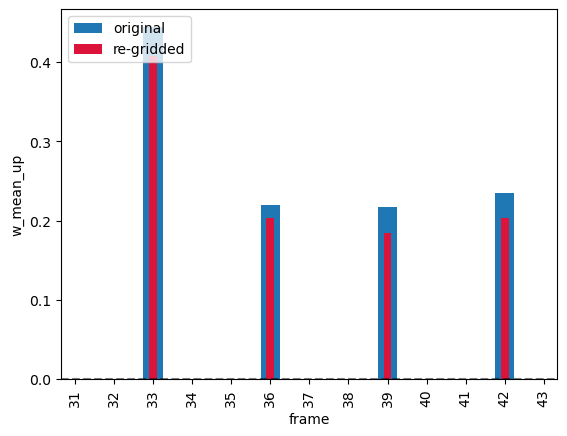

In [116]:
ax = subset_notgridded.plot(kind='bar',x='frame',y='w_mean_up',label='original')
subset.plot(ax=ax, kind='bar',x='frame',y='w_mean_up',label='re-gridded',color='crimson',width=0.2)
plt.ylabel('w_mean_up')
plt.axhline(y=0, ls='dashed', color='k',alpha=0.5)
plt.legend(loc='upper left')


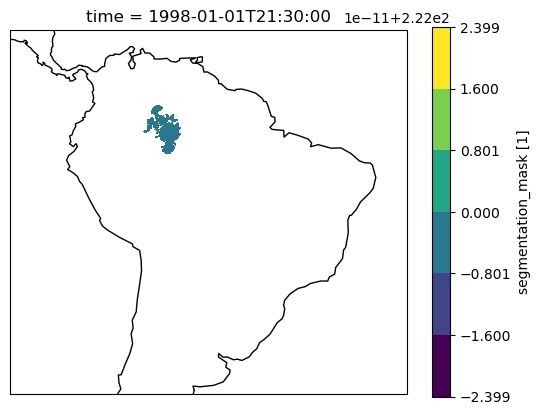

In [282]:
seg_mask = seg.where(labels == label)

#print(seg_mask)

ax = plt.axes(projection=ccrs.PlateCarree())
seg_mask.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),zorder=5)
ax.coastlines()


<xarray.DataArray 'upward_air_velocity' ()>
array(5.08886688)
Coordinates:
    time     datetime64[ns] 1998-01-01T21:00:00

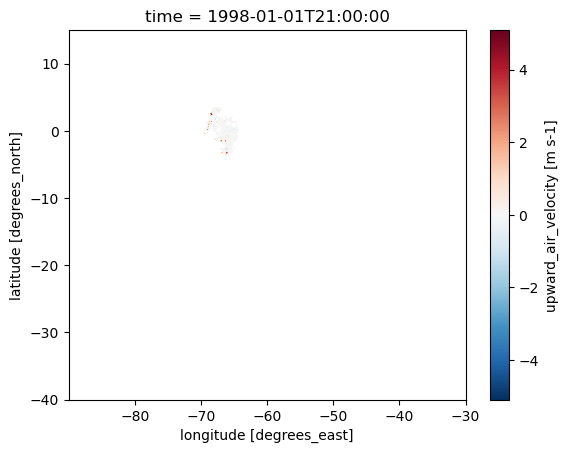

In [283]:
seg_mask.coords

seg_mask.coords['mask'] = (('latitude', 'longitude'), seg_mask.data)

vel_w.where(seg_mask.coords['mask'].values > 0).plot(zorder=1)

vel_w.where(seg_mask.coords['mask'].values > 0).max()


In [284]:
## Location of the precipitation maxima within the cloud shield at each timestep ##

da = prec.where(seg_mask.coords['mask'].values > 0)

da.where(da==da.max(), drop=True).squeeze().latitude

<xarray.DataArray 'latitude' ()>
array(2.45000005)
Coordinates:
    time       datetime64[ns] 1998-01-01T21:30:00
    latitude   float64 2.45
    longitude  float64 -68.35
Attributes:
    axis:           Y
    bounds:         latitude_bnds
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

611

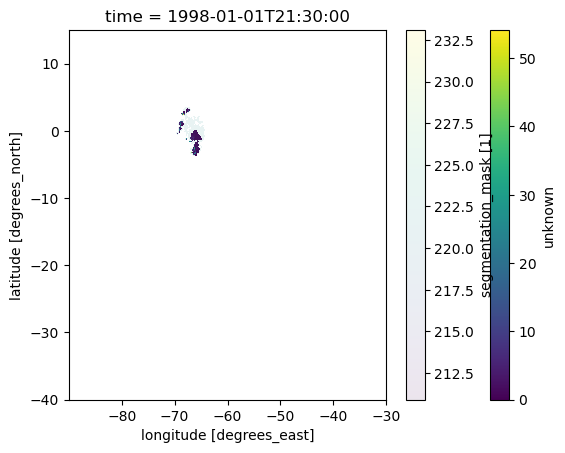

In [285]:
## code for the number of colocated pixels within each timestep of a cloud shield ##

#prec = prec * 3600 # converting from kg m-2 s-1 to mm/hr

colocated = prec.where((brightness_temp <= 210) & (seg_mask.coords['mask'].values > 0)) #finding only the locations where all tb and precip criteria are met
colocated.plot()
seg_mask.plot(alpha=0.1)

colocated_pixels = colocated.values[~np.isnan(colocated)].shape[0]
colocated_pixels

*** Animation for single cell (1209) over time showing all 3 variables (Tb, precip and w) within the masked area as well as maxima / minima locations ***

Text(0, 0.5, 'Lat $^\\circ$N')

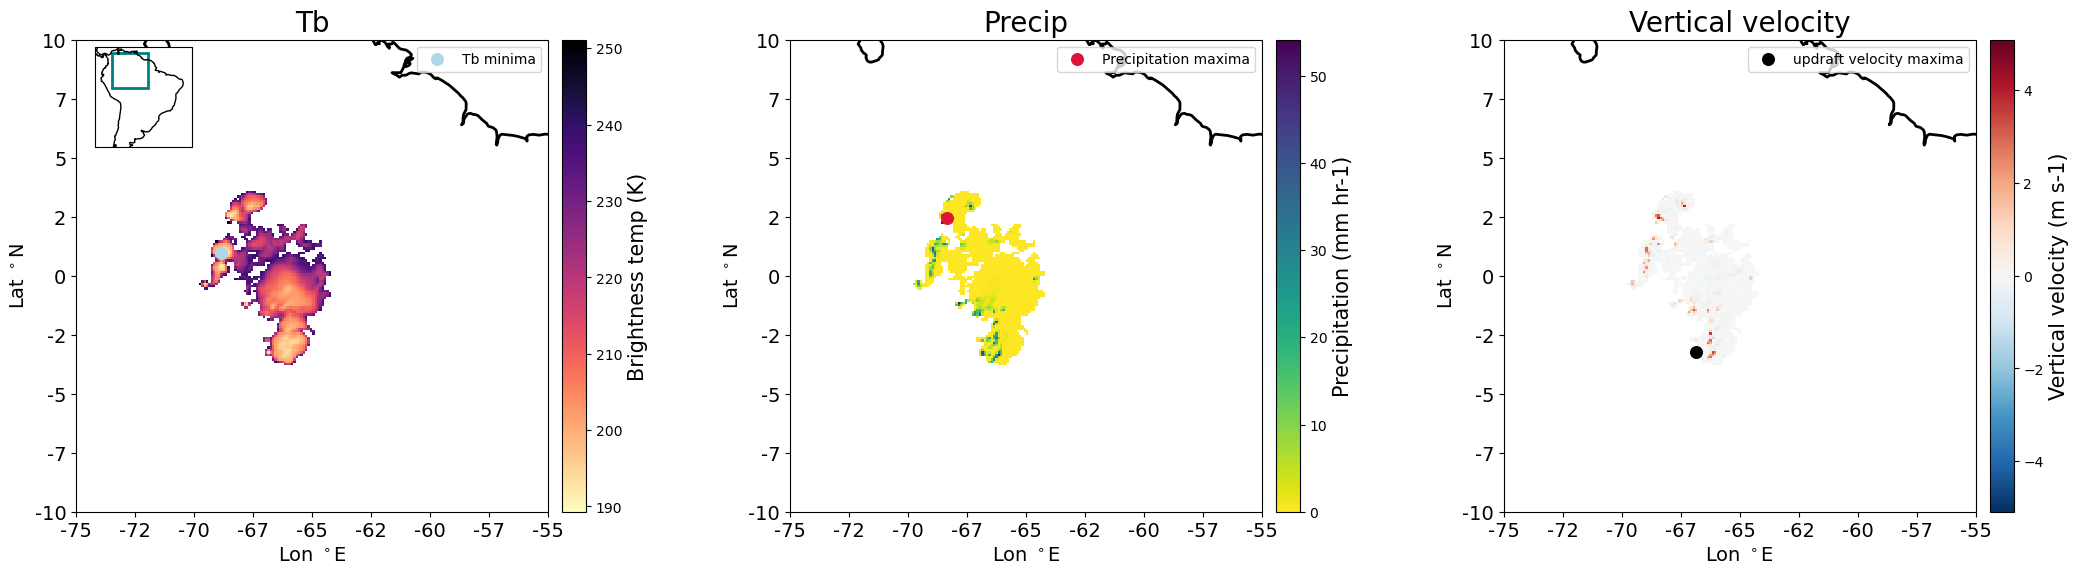

In [286]:
#plots for each timestep:
#========================
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
    
    if mappable == tb:
        label = 'Brightness temp (K)'
    elif mappable == precips:
        label = 'Precipitation (mm hr-1)'
    elif mappable == vel:
        label = 'Vertical velocity (m s-1)'
        
    cax = divider.append_axes(loc, '5%', pad='3%', axes_class=mpl.pyplot.Axes)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label).set_label(label=label,size=15)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label)

#creating list of dates and times for the plot titles:
# time = tb.coord('time')
# dates = time.units.num2date(time.points)
import cartopy as crs
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
#axis_extent=[-80,-30,-35,12]
xlabels=[-50,-40,-30]
ylabels= [-30,-20,-10]

# markersize 
s = 70
#fontsize
f=20

#loop for each timestep:
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace=0.4,hspace=0)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
#cbar1 = plt.colorbar(tb, ax=ax1, label= 'brightness temperature (K)', orientation='vertical', shrink=0.5)
tb = brightness_temp.where(seg_mask.coords['mask'].values > 0).plot(ax=ax1,zorder=1,cmap='magma_r', add_colorbar=False)
make_colorbar(ax1, tb, orientation='vertical')
ax1.coastlines(linewidth=2)
#gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, color='k',linestyle='--')
ax1.scatter(subset.min_tb_lon[subset.frame == frame].values[0],subset.min_tb_lat[subset.frame == frame].values[0],color='lightblue',marker='o', s = s, transform=ccrs.PlateCarree(),label='Tb minima')
ax1.set_title('Tb', loc='center', fontsize=f)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_xlim(-75,-55)
ax1.set_ylim(-10, 10)
ax1.legend(loc='upper right')
ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=14)
ax1.set_yticklabels(ax1.get_yticks().astype(int),fontsize=14)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=14)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=14)
axins = inset_axes(ax1, width=1.2, height=1, loc="upper left", 
                   axes_class=crs.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=crs.crs.PlateCarree(),extent=[-85,-30,-40,12]))
axins.add_feature(crs.feature.COASTLINE)
axins.add_patch(mpatches.Rectangle(xy=[-75, -10], width=20, height=20, linewidth=2,
                                facecolor='none', edgecolor='teal',
                                transform=ccrs.PlateCarree()))



ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
precips = prec.where(seg_mask.coords['mask'].values > 0).plot(ax=ax2,zorder=1,cmap='viridis_r',add_colorbar=False)
make_colorbar(ax2, precips, orientation='vertical')
ax2.scatter(subset.max_precip_lon[subset.frame == frame].values[0],subset.max_precip_lat[subset.frame == frame].values[0],color='crimson',marker='o', s = s, transform=ccrs.PlateCarree(),label='Precipitation maxima')
ax2.set_title('Precip', loc='center', fontsize=f)
ax2.coastlines(linewidth=2)
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlim(-75,-55)
ax2.set_ylim(-10,10)
ax2.legend(loc='upper right')
ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=14)
ax2.set_yticklabels(ax2.get_yticks().astype(int),fontsize=14)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=14)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=14)

ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
vel = vel_w.where(seg_mask.coords['mask'].values > 0).plot(ax=ax3,zorder=1, add_colorbar=False)
make_colorbar(ax3, vel, orientation='vertical')
ax3.scatter(subset.max_w_up_lon[subset.frame == frame].values[0],subset.max_w_up_lat[subset.frame == frame].values[0],color='k',marker='o', s = s, transform=ccrs.PlateCarree(), label='updraft velocity maxima')                                           
ax3.set_title('Vertical velocity', loc='center', fontsize=f)
ax3.coastlines(linewidth=2)
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlim(-75,-55)
ax3.set_ylim(-10,10)
ax3.legend(loc='upper right')
ax3.set_xticklabels(ax3.get_xticks().astype(int),fontsize=14)
ax3.set_yticklabels(ax3.get_yticks().astype(int),fontsize=14)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=14)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=14)



In [328]:
##ANIMATION CODE##
import PIL
import numpy as np
from PIL import Image

image_frames=[]

frames = np.arange(15,22)
#print(frames)

for k in frames:
        print('single_MCS_animation_frame_RG_no_precip' +str(k) + '.jpg')
        new_frame = PIL.Image.open('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_RG_no_precip' +str(k) + '.jpg')
        image_frames.append(new_frame)

image_frames[0].save('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_RG_no_precip.gif', format = 'GIF', append_images = image_frames[1: ], save_all = True, duration = 1200, loop = 3)

single_MCS_animation_frame_RG_no_precip15.jpg
single_MCS_animation_frame_RG_no_precip16.jpg
single_MCS_animation_frame_RG_no_precip17.jpg
single_MCS_animation_frame_RG_no_precip18.jpg
single_MCS_animation_frame_RG_no_precip19.jpg
single_MCS_animation_frame_RG_no_precip20.jpg
single_MCS_animation_frame_RG_no_precip21.jpg


**Looking closer at differences in single MCSs when kept in original but removed for no precip in regridded**

In [135]:
no_precip_regridded = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/final_tracks_CPM_REGRIDDED/merged/1998/no_precip_1998.hdf', 'table')
CCPF_original = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/final_tracks_CPM/merged/1998/CCPF_1998.hdf', 'table')

In [136]:
no_precip_regridded

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,convective_precip,heavy_precip,extreme_precip,heavy_rain_flag,extreme_rain_flag,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,...,tb_190,tb_180,w_max,w_min,w_mean,w_mean_up,w_mean_down,w_up_area,w_down_area,w_0.1_up,w_1_up,w_5_up,w_0.1_down,w_1_down,w_5_down,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
62313,5603,70,1123.430032,952.354815,2129,240,62314,1998-08-22 11:30:00,1998-08-22 11:30:00,5.458865,313.530421,14019,0 days 00:00:00,1103.164673,128,1072.040894,739.660645,0.000000,38,0,37.556976,3.151899,8.375319,197.224884,214.679932,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-08-22 11:30:00,5.85,-46.450001,5.35,-46.450001,0,0,0,0,79
62325,5604,69,1123.679166,948.871803,2491,240,62326,1998-08-22 12:30:00,1998-08-22 12:30:00,5.468955,313.389370,14019,0 days 01:00:00,1230.723145,139,1202.947510,807.255127,0.000000,40,0,41.975327,2.987192,8.654299,199.656784,218.233688,...,0,0,4.112953,-0.538776,0.089763,0.224097,-0.097680,240.0,172.0,86.0,16.0,0.0,59.0,0.0,0.0,1998-08-22 12:30:00,5.85,-45.75,5.85,-45.75,5.85,-45.650002,5.95,-46.650002,47
62334,5605,81,1123.755548,948.147809,2905,240,62335,1998-08-22 13:30:00,1998-08-22 13:30:00,5.472048,313.360051,14019,0 days 02:00:00,1377.794434,132,1347.232666,1040.131348,58.691177,46,1,58.691177,2.870405,10.206308,199.690506,220.236496,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-08-22 13:30:00,5.35,-45.650002,5.85,-45.950001,0,0,0,0,44
62343,5606,85,1122.503694,943.887686,3080,240,62344,1998-08-22 14:30:00,1998-08-22 14:30:00,5.421349,313.187499,14019,0 days 03:00:00,1534.815186,152,1499.666870,1074.368164,112.203644,46,2,62.026680,3.021290,9.866229,200.548965,221.463303,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-08-22 14:30:00,5.45,-46.650002,5.75,-47.25,0,0,0,0,46
62349,5607,85,1121.832784,940.126825,3018,240,62350,1998-08-22 15:30:00,1998-08-22 15:30:00,5.394179,313.035196,14019,0 days 04:00:00,1580.090454,140,1539.022217,1180.455444,447.721497,43,6,94.524895,3.231269,10.993016,194.390732,219.891418,...,0,0,5.720594,-0.520466,0.112994,0.321892,-0.069491,228.0,261.0,89.0,24.0,1.0,54.0,0.0,0.0,1998-08-22 15:30:00,5.55,-46.450001,5.55,-46.450001,5.55,-46.349998,5.65,-45.650002,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67312,6115,226,1174.118637,791.270550,7727,240,67313,1998-09-12 19:30:00,1998-09-12 19:30:00,7.511755,307.006501,15121,0 days 09:00:00,833.463623,75,803.569702,646.343018,119.040817,24,2,60.516697,0.657306,10.714263,193.580521,216.480331,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 19:30:00,7.25,-53.75,7.15,-54.150002,0,0,0,0,53
67323,6116,232,1177.736231,792.432884,7105,240,67324,1998-09-12 20:30:00,1998-09-12 20:30:00,7.658266,307.053572,15121,0 days 10:00:00,826.610046,75,802.971436,627.786987,53.077145,27,1,53.077145,0.705901,10.706285,195.064926,218.966599,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 20:30:00,7.75,-53.049999,7.35,-53.950001,0,0,0,0,36
67330,6117,234,1180.699601,792.982786,6309,240,67331,1998-09-12 21:30:00,1998-09-12 21:30:00,7.778285,307.075841,15121,0 days 11:00:00,901.517334,59,885.909607,769.914612,188.926361,24,3,71.468948,0.878672,15.015417,197.434570,221.584946,...,0,0,4.092428,-0.769858,0.008065,0.131784,-0.076306,416.0,610.0,50.0,13.0,0.0,140.0,0.0,0.0,1998-09-12 21:30:00,8.55,-50.849998,7.45,-53.950001,8.55,-50.349998,8.65,-50.049999,17
67338,6118,219,1188.882235,800.940420,6002,240,67339,1998-09-12 22:30:00,1998-09-12 22:30:00,8.109679,307.398130,15121,0 days 12:00:00,1033.109497,56,1018.521301,909.330811,319.995483,29

In [137]:
CCPF_original

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,convective_precip,heavy_precip,extreme_precip,heavy_rain_flag,extreme_rain_flag,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,...,tb_190,tb_180,w_max,w_min,w_mean,w_mean_up,w_mean_down,w_up_area,w_down_area,w_0.1_up,w_1_up,w_5_up,w_0.1_down,w_1_down,w_5_down,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
15651,1380,93,771.369817,211.990152,2412,240,15652,1998-02-27 12:30:00,1998-02-27 12:30:00,-8.799573,283.545652,3829,0 days 00:00:00,5355.662598,627,5183.308594,3400.977539,210.200928,145,4,54.172398,2.221345,8.266840,191.876343,213.798599,...,0,0,6.245428,-0.770148,0.116120,0.369728,-0.127384,1181.0,1230.0,536.0,112.0,6.0,484.0,0.0,0.0,1998-02-27 12:30:00,-8.004551,283.627045,-8.04505,283.546051,-8.510799,284.133301,-8.875299,283.3638,441
15660,1381,90,775.818514,218.611922,4572,240,15661,1998-02-27 13:30:00,1998-02-27 13:30:00,-8.619401,283.813843,3829,0 days 01:00:00,9654.384766,1120,9375.063477,6258.664062,1096.904419,254,16,95.511696,2.109326,8.370592,190.771011,214.785538,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-02-27 13:30:00,-8.20705,284.234558,-8.126051,284.234558,0,0,0,0,636
15670,1382,96,773.524616,217.623450,5171,240,15671,1998-02-27 14:30:00,1998-02-27 14:30:00,-8.712304,283.773813,3829,0 days 02:00:00,10956.796875,1035,10602.655273,7469.211914,3058.989746,243,42,130.999695,2.118074,10.244111,188.209641,215.083878,...,23,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-02-27 14:30:00,-7.92355,284.234558,-8.08555,284.194061,0,0,0,0,547
15679,1383,91,767.841475,228.466812,7251,240,15680,1998-02-27 15:30:00,1998-02-27 15:30:00,-8.942471,284.212966,3829,0 days 03:00:00,13494.519531,1359,13084.945312,9422.879883,3267.527588,330,47,118.886246,1.860030,9.628363,190.300110,215.242966,...,0,0,7.813848,-1.756472,0.058822,0.300728,-0.131652,3196.0,4059.0,1003.0,233.0,31.0,1591.0,17.0,0.0,1998-02-27 15:30:00,-9.50305,285.24704,-8.369051,284.113037,-8.510799,286.60379,-8.227299,284.173798,824
15691,1384,160,765.556522,225.455483,8047,240,15692,1998-02-27 16:30:00,1998-02-27 16:30:00,-9.035011,284.090986,3829,0 days 04:00:00,15722.656250,1541,15337.197266,10721.303711,4310.264648,356,56,143.169525,1.955311,9.952756,188.921143,214.815125,...,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-02-27 16:30:00,-10.758551,285.530548,-10.799051,285.530548,0,0,0,0,919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67312,6115,226,1174.118637,791.270550,7727,240,67313,1998-09-12 19:30:00,1998-09-12 19:30:00,7.511755,307.006501,15121,0 days 09:00:00,5090.797363,371,4988.981934,4122.369629,2028.004639,112,26,146.270691,0.658406,13.447391,193.396286,216.192764,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 19:30:00,7.304451,306.266541,7.101948,305.861542,0,0,0,0,276
67323,6116,232,1177.736231,792.432884,7105,240,67324,1998-09-12 20:30:00,1998-09-12 20:30:00,7.658266,307.053572,15121,0 days 10:00:00,5245.123047,367,5145.463379,4203.254395,2010.823486,115,27,119.608231,0.737296,14.020336,194.512955,218.671280,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 20:30:00,7.790451,306.995544,7.344948,306.064056,0,0,0,0,178
67330,6117,234,1180.699601,792.982786,6309,240,67331,1998-09-12 21:30:00,1998-09-12 21:30:00,7.778285,307.075841,15121,0 days 11:00:00,5620.993652,272,5551.640137,5028.349609,3177.761719,109,40,121.203781,0.891090,20.410442,196.456955,221.483902,...,0,0,8.357149,-1.313725,0.008459,0.146235,-0.087958,2597.0,3711.0,308.0,79.0,12.0,966.0,5.0,0.0,1998-09-12 21:30:00,8.559948,309.142059,7.425949,306.02356,8.620701,309.364777,8.701702,309.243286

In [141]:
CCPF_original_array = np.unique(CCPF_original.cell)
no_precip_regridded_array = np.unique(no_precip_regridded.cell)

In [163]:
no_precip_regridded_array.shape

(1722,)

In [164]:
## This finds the numbers of cells that meet the CCPF criteria in the original gridded CPM, but don't meet the 
## precip criteria in the regridded CPM
print(np.intersect1d(CCPF_original_array, no_precip_regridded_array))

[   35    48    59    61    64    79    83    96   112   117   130   132
   137   141   170   173   202   205   206   233   238   271   309   313
   333   335   339   340   391   455   468   500   533   540   549   563
   574   582   585   615   631   644   660   729   737   752   756   759
   769   792   821   822   834   849   855   856   864   891   900  1039
  1046  1080  1110  1131  1155  1159  1193  1216  1264  1298  1316  1324
  1372  1382  1386  1398  1400  1406  1421  1437  1451  1452  1477  1534
  1542  1685  1718  1754  1755  1761  1766  1778  1781  1792  1794  1805
  1808  1810  1826  1843  1854  1870  1884  1898  1906  1914  1929  1938
  1951  1958  1971  1977  1983  2040  2045  2046  2050  2090  2099  2110
  2115  2122  2126  2160  2173  2176  2185  2225  2231  2237  2240  2241
  2277  2292  2296  2308  2322  2343  2356  2372  2381  2391  2392  2433
  2464  2475  2479  2492  2524  2667  2740  2776  2821  2822  2849  2900
  2902  2907  2925  2930  2968  2992  3000  3004  3